<a href="https://colab.research.google.com/github/Bschreff/Heath-Care-Predictions/blob/main/Stroke.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **STROKE PREDICTIONS**
#### **Brian Schreffler**

## **Import Libraries**

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## **Load Data**

In [2]:
df = pd.read_csv('/content/drive/MyDrive/stack 2/healthcare-dataset-stroke-data.csv', index_col='id')
ml_df = df.copy
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


## **Inspect Data**

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5110 entries, 9046 to 44679
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 479.1+ KB


In [4]:
print(f'There are {df.shape[0]} rows, and {df.shape[1]} columns.')
print(f'The rows represent {df.shape[0]} observations, and the columns represent {df.shape[1]-1} features and 1 target.')

There are 5110 rows, and 11 columns.
The rows represent 5110 observations, and the columns represent 10 features and 1 target.


In [5]:
# Display the column names and datatypes for each column
# Columns with mixed datatypes are identified as an object datatype
df.dtypes

gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

In [6]:
# Display the column names, count of non-null values, and their datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5110 entries, 9046 to 44679
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 479.1+ KB


In [7]:
# Checkin Missing Data
df.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

  - BMI has missing values after splitting the data I will Impute the mean.

In [8]:
# Display the descriptive statistics for the numeric columns
df.describe(include="number")

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [9]:
# Display the descriptive statistics for the numeric columns
df.describe(include='object') 

,gender,ever_married,work_type,Residence_type,smoking_status
count,5110,5110,5110,5110,5110
unique,3,2,5,2,4
top,Female,Yes,Private,Urban,never smoked
freq,2994,3353,2925,2596,1892


## **Clean the Data**

### **Duplicates**

  - There are 0 duplicates

### **Remove Unnecessary Columns**

 - ID has been changed to index. no unnecessary columns to be removed.

### **Remove Duplicated Rows**

In [10]:
# Display the number of duplicate rows in the dataset
print(f'There are {df.duplicated().sum()} duplicate rows.')

There are 0 duplicate rows.


### **Inspect Column Datatypes for Errors**

In [11]:
 # Display column names and datatypes
df.dtypes

gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

### **Inspect Column Names for Errors**

In [12]:
# Display column names
df.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

### **Check Value Counts**

In [13]:
dtypes = df.dtypes
str_cols = dtypes[dtypes == 'object'].index
str_cols

Index(['gender', 'ever_married', 'work_type', 'Residence_type',
       'smoking_status'],
      dtype='object')

In [14]:
for col in str_cols:
  print(f'- Column = {col}')
  print(df[col].value_counts(dropna = False))
  print('\n\n')

- Column = gender
Female    2994
Male      2115
Other        1
Name: gender, dtype: int64



- Column = ever_married
Yes    3353
No     1757
Name: ever_married, dtype: int64



- Column = work_type
Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64



- Column = Residence_type
Urban    2596
Rural    2514
Name: Residence_type, dtype: int64



- Column = smoking_status
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64





  - All the Categorical Data Values look good.

## **Univariate visuals for the target and all features.**

### **Target Exploratory Visual**

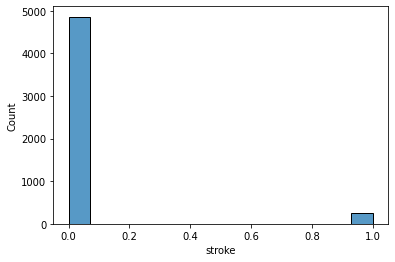

In [15]:
sns.histplot(data = df, x = 'stroke');

  - The Data is unbalanced more Negatives than Positives.

### **Feature Exploratory Visuals**

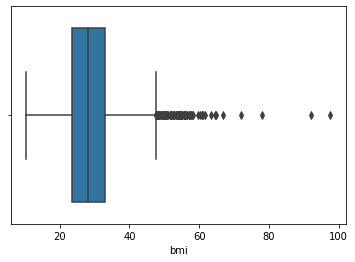

In [16]:
sns.boxplot(data = df, x = 'bmi');

  - BMI has Outliers.

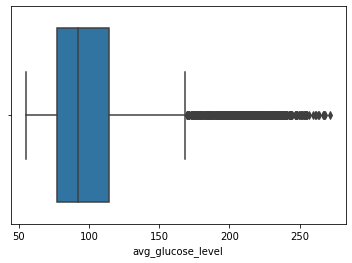

In [17]:
sns.boxplot(data = df, x = 'avg_glucose_level');

  - Average Glucose Level has Outliers.

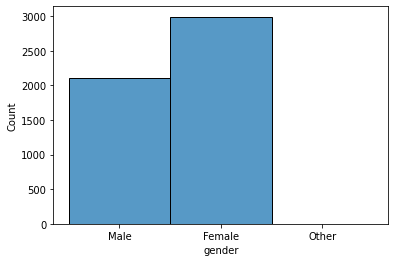

In [18]:
sns.histplot(data = df, x = 'gender');

  - About a Thousand More Women In The Data Set.

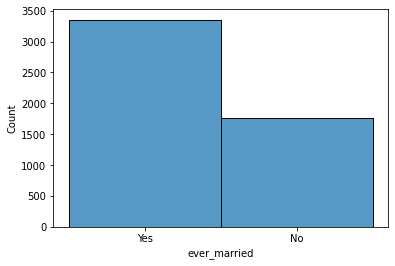

In [19]:
sns.histplot(data = df, x = 'ever_married');

  - Twice as Many People in the Data Sets are Married.

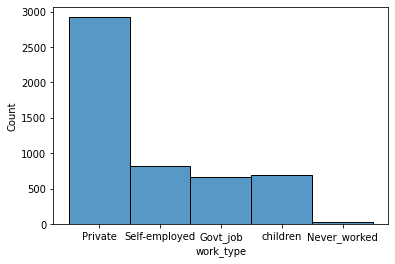

In [20]:
sns.histplot(data = df, x = 'work_type');

  - More people are Privately Employed. The rest of the Data is Fairly even.

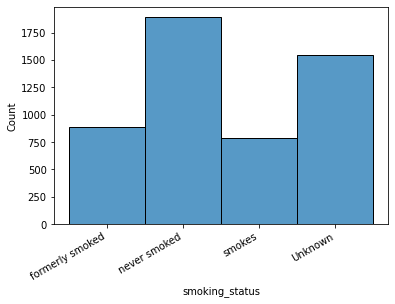

In [21]:
sns.histplot(data = df, x= 'smoking_status');
plt.xticks(rotation = 30,horizontalalignment='right');

  - There is a good amount of Unknown in smoking data.

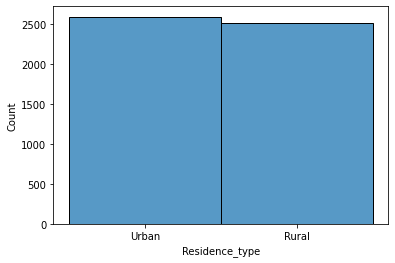

In [22]:
sns.histplot(data = df, x = 'Residence_type');

  - Residence Data is fairly even.

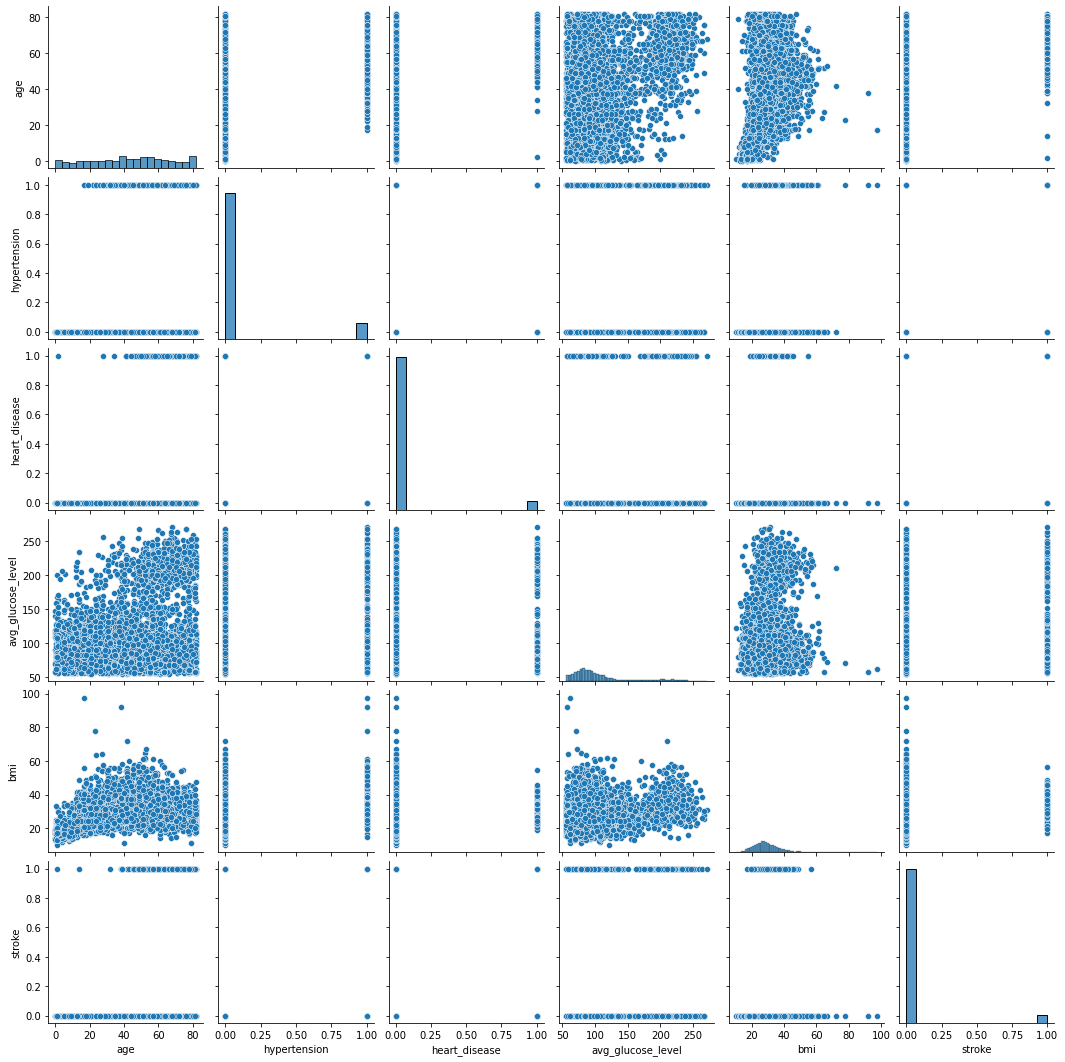

In [23]:
sns.pairplot(df.iloc[:, [1,2,3,7,8,10]]);

## **Checking Correlation**
  - With Heat Map

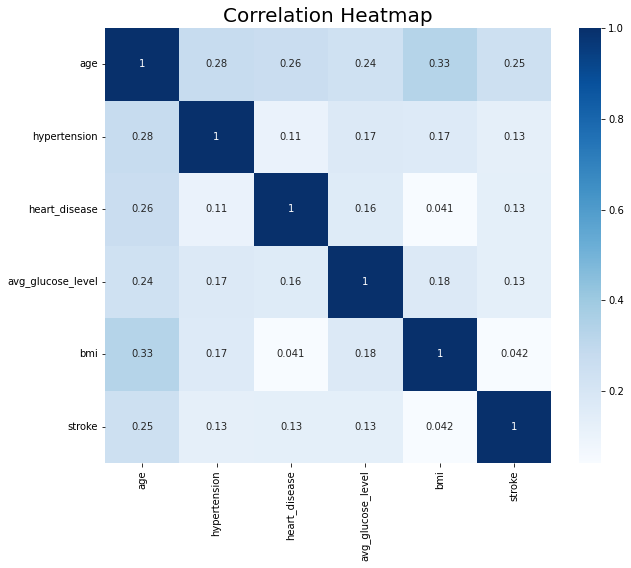

In [24]:
corr = df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap = 'Blues', annot = True);
sns.set_context('poster')
plt.style.use(['dark_background', 'seaborn-muted']);
plt.title('Correlation Heatmap', fontsize = 20);

## **Multivariant Visualization**

#### Line Plot of BMI and Stroke

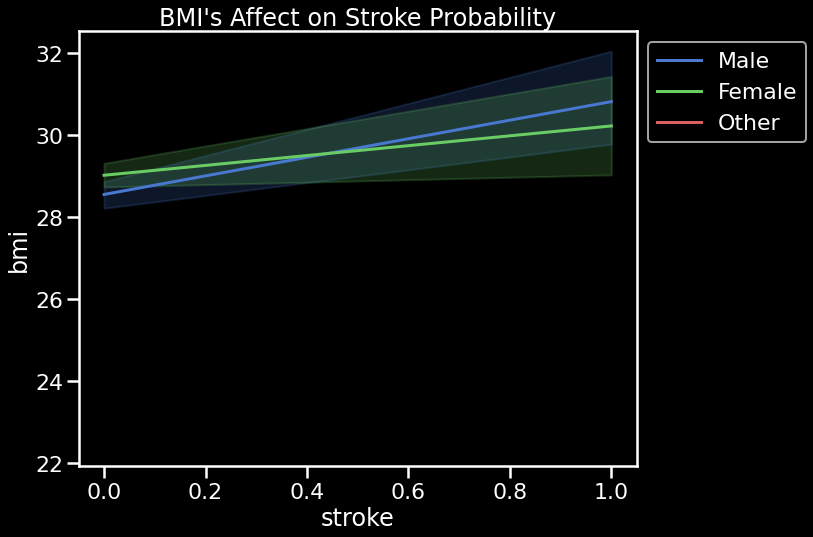

In [25]:
plt.figure(figsize=(10,8))
sns.lineplot(data = df, y='bmi',x='stroke', hue = 'gender').set(title=
"BMI's Affect on Stroke Probability")
sns.set_context('poster')
plt.style.use(['dark_background', 'seaborn-muted']);
plt.legend(bbox_to_anchor = (1,1));

  - The higher the BMI the more likely to have a stroke. 

#### Line Plot of Heart Disease affect on Stroke

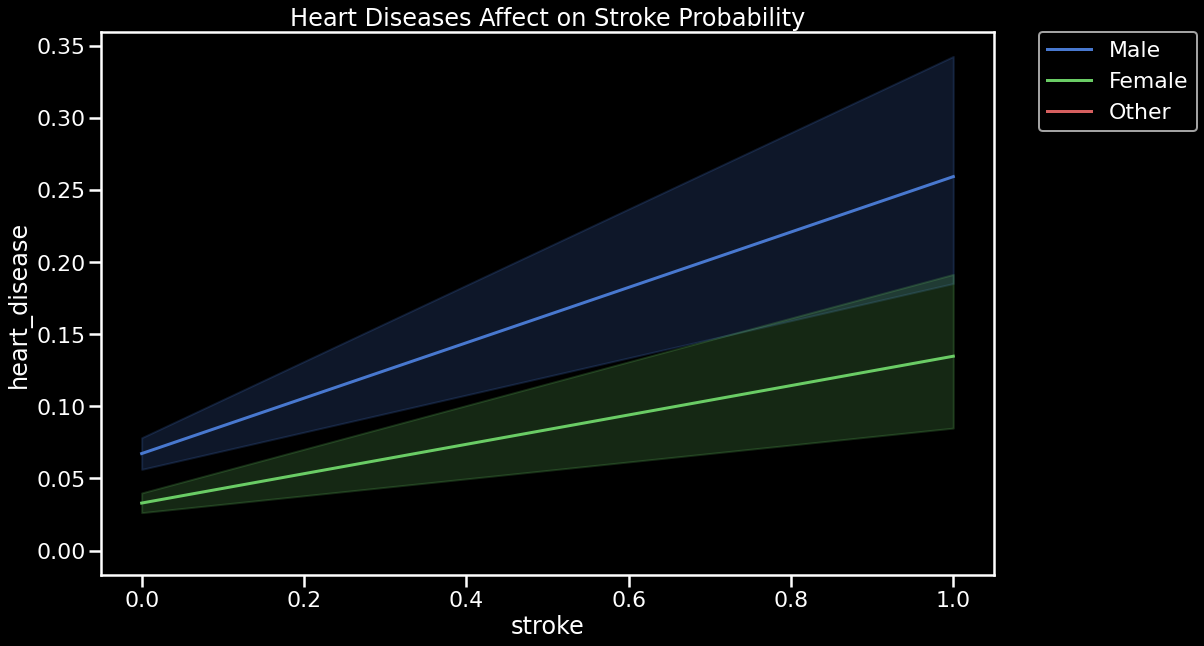

In [26]:
plt.figure(figsize=(16,10))
sns.lineplot(data = df, x='stroke',y='heart_disease', hue = 'gender').set(title="Heart Diseases Affect on Stroke Probability");
sns.set_context('poster')
plt.style.use(['dark_background', 'seaborn-muted'])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0);

  - Heart Disease has a small increase on the probability of having a Stroke.

#### Age affects on Stroke

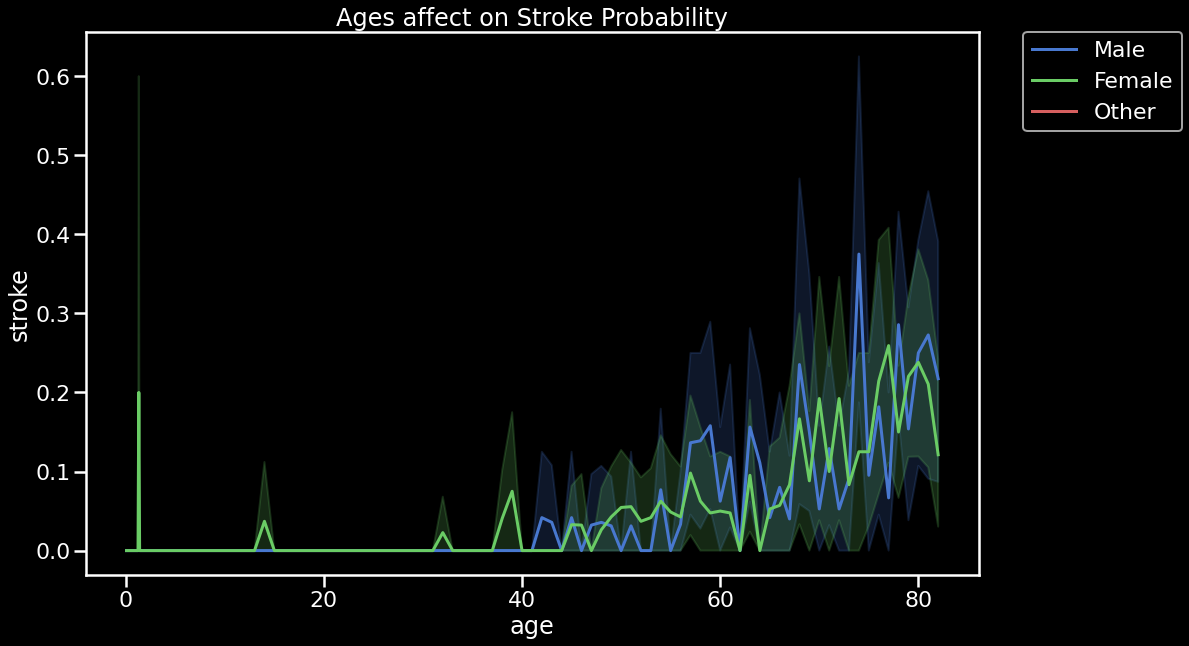

In [27]:
plt.figure(figsize=(16,10))
sns.lineplot(data = df, y='stroke',x='age', hue = 'gender').set(title = 'Ages affect on Stroke Probability')
sns.set_context('poster')
plt.style.use(['dark_background', 'seaborn-muted']);
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0);

  - There is more frequency for a stroke as you get older.

#### Hypertension affect on Stroke

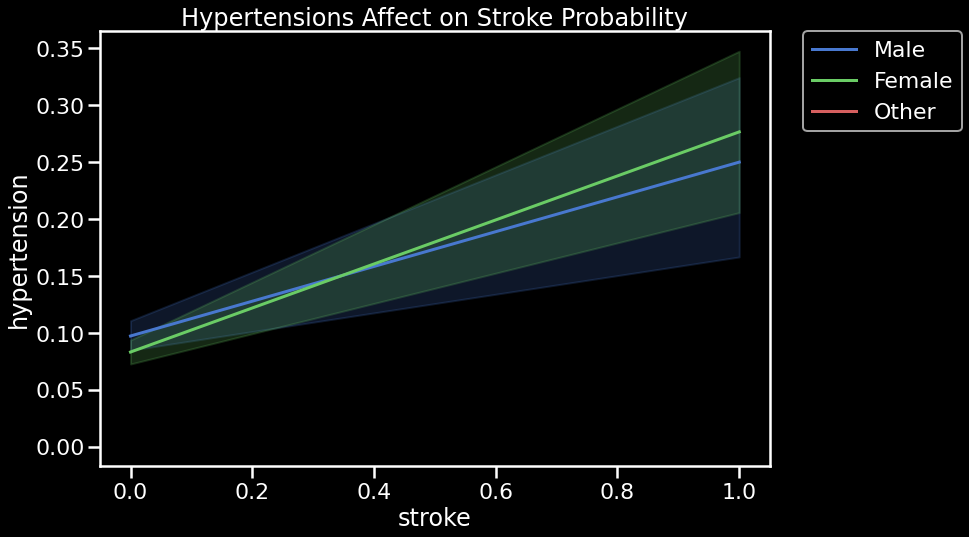

In [28]:
plt.figure(figsize=(12,8))
sns.lineplot(data = df, x='stroke',y='hypertension', hue = 'gender').set(title='Hypertensions Affect on Stroke Probability')
sns.set_context('poster')
plt.style.use(['dark_background', 'seaborn-muted'])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0);

  - Hypertension raise chances of Stroke.

## Visuals to Present to Stake Holders

#### Glucose levels affect on Stroke

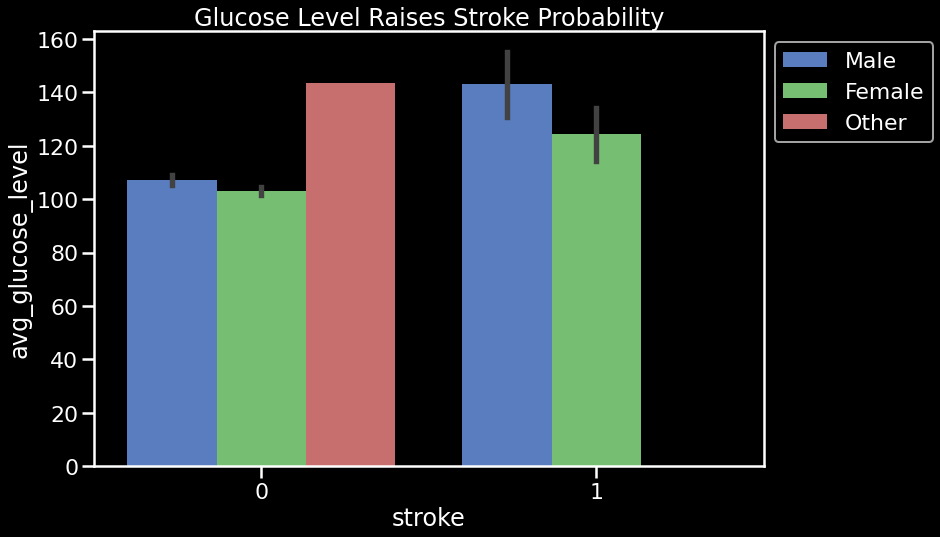

In [29]:
plt.figure(figsize=(12,8))
sns.barplot(data = df, x='stroke',y='avg_glucose_level', hue = 'gender');
sns.set_context('poster')
plt.style.use(['dark_background', 'seaborn-muted'])
plt.title('Glucose Level Raises Stroke Probability')
plt.legend(bbox_to_anchor = (1,1));

  - People that have had strokes have a higher glucose level. 

#### Heart Disease affect on Stroke

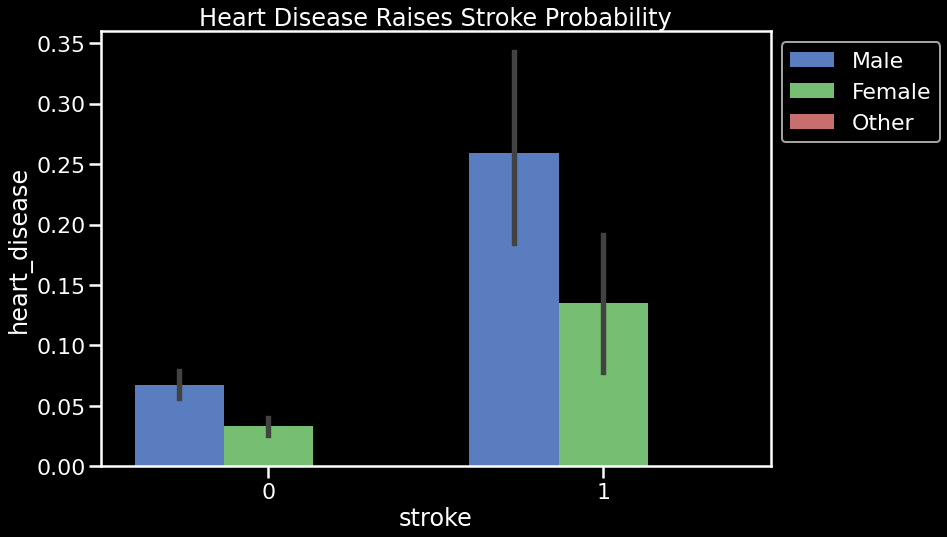

In [31]:
plt.figure(figsize=(12,8))
sns.barplot(data = df, x='stroke',y='heart_disease', hue = 'gender');
sns.set_context('poster')
plt.style.use(['dark_background', 'seaborn-muted'])
plt.title('Heart Disease Raises Stroke Probability')
plt.legend(bbox_to_anchor = (1,1));

  - Heart disease increases the possibility of a stroke.